
# Introduction to Social Data Science: Text as Data

#### Required readings

*(PML) Raschka, Sebastian, and Mirjalili, Vahid. Python Machine Learning - Second Edition. Birmingham: Packt Publishing, Limited, 2017. Chapter 8*

- PML: following sections from chapter 8:
  - Preparing the IMDb movie review data for text processing
  - Introducing the bag-of-words model
  - Training a logistic regression model for document classification
 
Gentzkow, M., Kelly, B.T. and Taddy, M., 2017. ["Text as data"](http://www.nber.org/papers/w23276.pdf) (No. w23276). *National Bureau of Economic Research*.

Jurafsky, D., & Martin, J. H. (2019). Vector Semantics and Embeddings. Speech and Language Processing, 3rd ed. draft. https://web.stanford.edu/~jurafsky/slp3/6.pdf




#### Inspirational readings

Gorrell, Genevieve et al. “Twits, Twats and Twaddle: Trends in Online Abuse towards UK Politicians.” ICWSM (2018). https://gate-socmedia.group.shef.ac.uk/wp-content/uploads/2019/07/Gorrell-Greenwood.pdf

Pang, Bo et al. “Thumbs up? Sentiment Classification using Machine Learning Techniques.” EMNLP (2002). https://www.aclweb.org/anthology/W02-1011.pdf 







Course page: https://isdsucph.github.io/isds2021/

**Agenda**
- Preprocessing text
- Feature extraction
- Text classification with ML and using lexicons

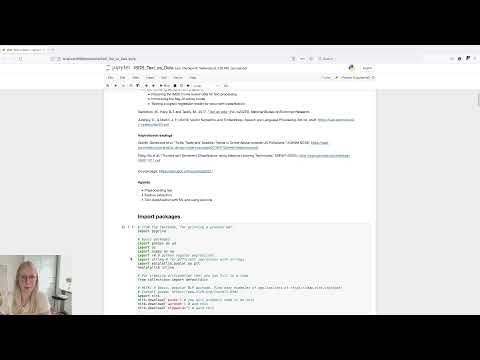

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('XJFB6-qpyTs', width=740, height=460)

## Import packages

In [4]:
# from the textbook, for printing a process bar.
import pyprind

# basic packages
import pandas as pd
import os
import numpy as np
import re # python regular expressions
import string # for efficient operations with strings
import matplotlib.pyplot as plt
%matplotlib inline

# For creating dictionaries that you can fill in a loop
from collections import defaultdict

# NLTK: A basic, popular NLP package. Find many examples of applications at https://www.nltk.org/book/
# Install guide: https://www.nltk.org/install.html
import nltk
nltk.download('punkt') # you will probably need to do this
nltk.download('wordnet') # and this
nltk.download('stopwords') # aand this

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vader Lexicon for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# for classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Lexicons for sentiment analysis
from vaderSentiment import vaderSentiment
from afinn import Afinn

# to display images in notebook
from IPython.display import Image

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Preparing data (following PML chapter 8)

Data source:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Download from http://ai.stanford.edu/~amaas/data/sentiment/




In [5]:
# download the data
import wget
wget.download("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")


100% [........................................................................] 84125825 / 84125825

'aclImdb_v1.tar.gz'

In [6]:
# unpack
import tarfile
with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
    tar.extractall()

In [7]:
# load data into a pandas DataFrame

basepath = "aclImdb"

labels = {"pos":1, "neg":0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ("test", "train"):
    for l in ("pos", "neg"):
        path = os.path.join(basepath,s,l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path,file), "r", encoding="utf-8") as infile:
                txt = infile.read()
            # Here I also append s ("train" or "test") to later use the predefined 
            # split of the data. They didn't do this in the textbook.
            df = df.append([[txt, labels[l], s]], ignore_index=True) 
            pbar.update()
df.columns = ["review", "sentiment", "set"]

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:20


In [8]:
df # look at the dataframe

,review,sentiment,set
0,I went and saw this movie last night after bei...,1,test
1,Actor turned director Bill Paxton follows up h...,1,test
2,As a recreational golfer with some knowledge o...,1,test
3,"I saw this film in a sneak preview, and it is ...",1,test
4,Bill Paxton has taken the true story of the 19...,1,test
...,...,...,...
49995,"Towards the end of the movie, I felt it was to...",0,train
49996,This is the kind of movie that my enemies cont...,0,train
49997,I saw 'Descent' last night at the Stockholm Fi...,0,train
49998,Some films that you pick up for a pound turn o...,0,train


In [9]:
# dividing into train and test set again.
df_train = df[df.set=="train"]
df_test = df[df.set=="test"]

# Permute data such that pos and neg samples are mixed

np.random.seed(0)
df_train = df.reindex(np.random.permutation(df_train.index))
df_test = df.reindex(np.random.permutation(df_test.index))

# save dataframes:
df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [10]:
# load saved dataframes:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,review,sentiment,set
0,Forbidden Siren is based upon the Siren 2 Play...,0,train
1,You better see this episode from the beginning...,1,train
2,This is one of those movies that's trying to b...,0,train
3,I have seen this film numerous times and for t...,1,train
4,Let's face it: the final season (#8) was one o...,1,train


# Preprocessing

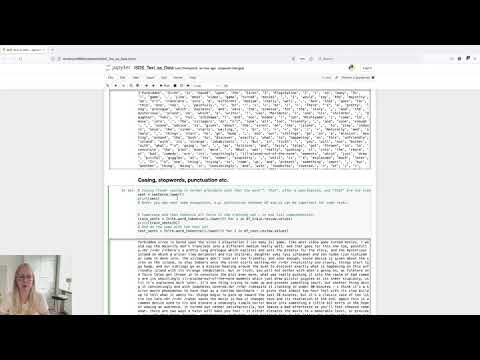

In [11]:
YouTubeVideo('mz9uPDsOER8', width=740, height=460)

We preprocess text data to standardize the format and to define what a unique "feature" is.
 
 
 *What is a feature?* 
 Features are the independent variables. A flower may have features such as color and leaf length, and you can use such features to classify flowers into species. 
 With text data, a feature is commonly a word (or a character in some special cases). If we have a small collection of texts where 2500 *unique* words are used, we commonly say that the *vocabulary* is of size 2500 and the number of features is equal to the size of the vocabulary.
 
 For most types of analysis, we have to represent each feature with some numerical values. But, this is where the importance of preprocessing comes in: Should the words "try" and "trying" have different values or do they convey the same basic information? What about "USA" and "usa"? And are punctuations important? 

 
When working with text as data, the number of features is much larger than when working with most other types as data. Preproccessing is therefore both about standardizing the data and about trying to reduce the number of features to relieve the computation cost.

The most standard preprocessing steps are:

- Segmentation (dividing a string into reasonable sentences and words)
- Lowercasing (standardizing)
- Stemming or lemmatizing (standardizing)
- Removing so-called stopwords and punctuation and other potentially disrupting text patterns (reducing "noise" and feature dimensionality)


What features are important, and hence which preprocessing steps should be included/excluded, depends on the task / research question.
 

## Tokenization (segmentation)

In [12]:
sentence = df_train.review.values[0]
print(sentence)
 
# word tokenization (segmentation)
# by blank space (crude)
sent = sentence.split(" ")
print(sent)
# by using a package such as NLTK.
sent = nltk.tokenize.word_tokenize(sentence)
print(sent)
# nltk.tokenize.TweetTokenizer() is another option, and good for social media text.

# Sentence segmentation (sentence splitting)
sents = nltk.tokenize.sent_tokenize(sentence)
print(sents)

# There are many other more complex versions used for specific cases/tasks/models and sometime you may want to costumize the segmentation.
# Learn more: https://web.stanford.edu/~jurafsky/slp3/2.pdf

Forbidden Siren is based upon the Siren 2 Playstation 2 (so many 2s) game. Like most video game turned movies, I would say the majority don't translate into a different medium really well. And that goes for this one too, painfully.<br /><br />There's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (Leo Morimoto) and his children, daughter Yuki (Yui Ichikawa) and son Hideo (Jun Nishiyama) come to move into. The villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />Naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. But in truth, you will not bother with what's going on, as folklore and fairy tales get thrown in to convolute the plot even more. What was really push

## Stemming or lemmatising

**Stemming**: Stripping the word down to it's central meaning (it's stem) by removing affixes. Stemming usually only removes suffixes (i.e. affixes at the end of the words).

E.g.: 

sings --> sing

laughing --> laugh

wonderful --> wonder


**Lemmatizing**: "the task of determining that two words have the same root, despite their surface differences. For example, the words sang, sung, and sings are forms of the verb sing. The word sing is the common lemma of these words, and a lemmatizer maps from all of these to sing." (Jurafsky, D., & Martin, J. H., 2019. Chap. 2, p. 2)


In [13]:
def stem(word):
    # find suffixes and return stems
    # (.*?) matches any character in front of a word (non greedy version)
    regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
    stem, suffix = re.findall(regexp, word)[0]
    return stem

# Tokenize the text first
tokens = nltk.word_tokenize(sentence)
print(tokens)

print([stem(t) for t in tokens]) # hmm not so good

['Forbidden', 'Siren', 'is', 'based', 'upon', 'the', 'Siren', '2', 'Playstation', '2', '(', 'so', 'many', '2s', ')', 'game', '.', 'Like', 'most', 'video', 'game', 'turned', 'movies', ',', 'I', 'would', 'say', 'the', 'majority', 'do', "n't", 'translate', 'into', 'a', 'different', 'medium', 'really', 'well', '.', 'And', 'that', 'goes', 'for', 'this', 'one', 'too', ',', 'painfully.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'There', "'s", 'a', 'pretty', 'long', 'prologue', 'which', 'explains', 'and', 'sets', 'the', 'premise', 'for', 'the', 'story', ',', 'and', 'the', 'mysterious', 'island', 'on', 'which', 'a', 'writer', '(', 'Leo', 'Morimoto', ')', 'and', 'his', 'children', ',', 'daughter', 'Yuki', '(', 'Yui', 'Ichikawa', ')', 'and', 'son', 'Hideo', '(', 'Jun', 'Nishiyama', ')', 'come', 'to', 'move', 'into', '.', 'The', 'villagers', 'do', "n't", 'look', 'all', 'too', 'friendly', ',', 'and', 'soon', 'enough', ',', 'sound', 'advice', 'is', 'given', 'about', 'the', 'siren', 'on', 'the', 'is

In [14]:
# using NLTK's Porter stemmer
porter = nltk.PorterStemmer()
#print(sentence)
print([porter.stem(t) for t in tokens])

['forbidden', 'siren', 'is', 'base', 'upon', 'the', 'siren', '2', 'playstat', '2', '(', 'so', 'mani', '2s', ')', 'game', '.', 'like', 'most', 'video', 'game', 'turn', 'movi', ',', 'i', 'would', 'say', 'the', 'major', 'do', "n't", 'translat', 'into', 'a', 'differ', 'medium', 'realli', 'well', '.', 'and', 'that', 'goe', 'for', 'thi', 'one', 'too', ',', 'painfully.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'there', "'s", 'a', 'pretti', 'long', 'prologu', 'which', 'explain', 'and', 'set', 'the', 'premis', 'for', 'the', 'stori', ',', 'and', 'the', 'mysteri', 'island', 'on', 'which', 'a', 'writer', '(', 'leo', 'morimoto', ')', 'and', 'hi', 'children', ',', 'daughter', 'yuki', '(', 'yui', 'ichikawa', ')', 'and', 'son', 'hideo', '(', 'jun', 'nishiyama', ')', 'come', 'to', 'move', 'into', '.', 'the', 'villag', 'do', "n't", 'look', 'all', 'too', 'friendli', ',', 'and', 'soon', 'enough', ',', 'sound', 'advic', 'is', 'given', 'about', 'the', 'siren', 'on', 'the', 'island', ',', 'to', 'stay', 'in

In [15]:
# using the WordNet lemmatizer through NLTK
# WordNet is a large lexical database of English (think "lexicon")
wnl = nltk.WordNetLemmatizer()
print(tokens)
print([wnl.lemmatize(t) for t in tokens])
# note the differences.. this lemmatizer knows that the word "based" does not have the same meaning as "base" here. 
# Seems more comprehensible. Or lot less has actually changed. (examples: "goes" became "go" and "villagers" became "villager")

['Forbidden', 'Siren', 'is', 'based', 'upon', 'the', 'Siren', '2', 'Playstation', '2', '(', 'so', 'many', '2s', ')', 'game', '.', 'Like', 'most', 'video', 'game', 'turned', 'movies', ',', 'I', 'would', 'say', 'the', 'majority', 'do', "n't", 'translate', 'into', 'a', 'different', 'medium', 'really', 'well', '.', 'And', 'that', 'goes', 'for', 'this', 'one', 'too', ',', 'painfully.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'There', "'s", 'a', 'pretty', 'long', 'prologue', 'which', 'explains', 'and', 'sets', 'the', 'premise', 'for', 'the', 'story', ',', 'and', 'the', 'mysterious', 'island', 'on', 'which', 'a', 'writer', '(', 'Leo', 'Morimoto', ')', 'and', 'his', 'children', ',', 'daughter', 'Yuki', '(', 'Yui', 'Ichikawa', ')', 'and', 'son', 'Hideo', '(', 'Jun', 'Nishiyama', ')', 'come', 'to', 'move', 'into', '.', 'The', 'villagers', 'do', "n't", 'look', 'all', 'too', 'friendly', ',', 'and', 'soon', 'enough', ',', 'sound', 'advice', 'is', 'given', 'about', 'the', 'siren', 'on', 'the', 'is

## Casing, stopwords, punctuation etc.

In [16]:
# Casing (lower casing is normal procedure such that the word ". That", after a punctuation, and "that" are not treated as two seperate features.
sent = sentence.lower()
print(sent)
# Note: you may want some exceptions, e.g. distinction between US and us can be important for some tasks.


# lowercase and then tokenize all texts in the training set – in one list comprehension (takes a minute or two):
train_sents = [nltk.word_tokenize(i.lower()) for i in df_train.review.values]
print(train_sents[0])
# And do the same with the test set
test_sents = [nltk.word_tokenize(i.lower()) for i in df_test.review.values]


forbidden siren is based upon the siren 2 playstation 2 (so many 2s) game. like most video game turned movies, i would say the majority don't translate into a different medium really well. and that goes for this one too, painfully.<br /><br />there's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (leo morimoto) and his children, daughter yuki (yui ichikawa) and son hideo (jun nishiyama) come to move into. the villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. but in truth, you will not bother with what's going on, as folklore and fairy tales get thrown in to convolute the plot even more. what was really push

In [17]:
# Removing certain words (stopwords)
stop_words_list = nltk.corpus.stopwords.words("english")
print(stop_words_list)
print()
sent_sw_removed = [i for i in nltk.word_tokenize(sentence.lower()) if i not in stop_words_list]
print(sent_sw_removed)
#train_sents_sw_removed = [[i for i in sent if i not in stop_words_list] for sent in train_sents] # nested list comprehension; lists in list.
#test_sents_sw_removed = [[i for i in sent if i not in stop_words_list] for sent in test_sents]
#print(train_sents_sw_removed[0])

# unfortunately the tokenization does not totally align with the stopwords – the simple split at whitespace may be more appropiate before stopword removal.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
# Removing punctuation, two ways:

punct_removed_1 = sentence.translate(str.maketrans('', '', string.punctuation))
print(punct_removed_1)

#def removePunctuation (word):
#    return re.sub("[^\w\s\-\']", "", word)

punct_removed_2 = re.sub(r'[^\w\s]','',sentence) # learn more about regex at https://www.datacamp.com/community/tutorials/python-regular-expression-tutorial or find a cheat sheet.
print(punct_removed_2)

Forbidden Siren is based upon the Siren 2 Playstation 2 so many 2s game Like most video game turned movies I would say the majority dont translate into a different medium really well And that goes for this one too painfullybr br Theres a pretty long prologue which explains and sets the premise for the story and the mysterious island on which a writer Leo Morimoto and his children daughter Yuki Yui Ichikawa and son Hideo Jun Nishiyama come to move into The villagers dont look all too friendly and soon enough sound advice is given about the siren on the island to stay indoors once the siren starts wailingbr br Naturally and slowly things start to go bump and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants But in truth you will not bother with whats going on as folklore and fairy tales get thrown in to convolute the plot even more What was really pushing it into the realm of bad comedy are it

## Exercise 1: preprocessing
Make a preprocessing function that takes a single string and 
 1) Lowercase the words,
 2) split the text into words (tokenize), 
 3) either stem or lemmatize words.
Feel free to add more steps of preprocessing. For example stopword removal or removal of what seems to be HTML elements (such as "< br/>") in the text, and removal of punctuation, and handling of emoticons as in the textbook.

In [19]:
def preprocess(text):
    
    # YOUR CODE HERE
    #1. lowercase the words
    text = text.lower()
    
    #(opt.: remove HTML elements)
    text = re.sub(r'<br /><br />',' ', text)
           
    #(opt.: remove "," and ".")
    text = re.sub(r'[^\w\s]','', text)
    
    #print(text)
    
    #2. tokenize (aka split the text-string into individual words)
    tokens = nltk.tokenize.word_tokenize(text)
    
    #(optional: remove stopwords)
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens_wo_sw = [t for t in tokens if t not in stop_words_list]

    #print(tokens_wo_sw)
    
    #3. stem or lemmatize words
    wnl = nltk.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(t) for t in tokens_wo_sw]
    
    #(opt.: handle emoticons)
    
    return lemmas # return a list of stems/lemmas

sentence = df_train.review.values[0]
print(preprocess(sentence))


['forbidden', 'siren', 'based', 'upon', 'siren', '2', 'playstation', '2', 'many', '2', 'game', 'like', 'video', 'game', 'turned', 'movie', 'would', 'say', 'majority', 'dont', 'translate', 'different', 'medium', 'really', 'well', 'go', 'one', 'painfully', 'there', 'pretty', 'long', 'prologue', 'explains', 'set', 'premise', 'story', 'mysterious', 'island', 'writer', 'leo', 'morimoto', 'child', 'daughter', 'yuki', 'yui', 'ichikawa', 'son', 'hideo', 'jun', 'nishiyama', 'come', 'move', 'villager', 'dont', 'look', 'friendly', 'soon', 'enough', 'sound', 'advice', 'given', 'siren', 'island', 'stay', 'indoors', 'siren', 'start', 'wailing', 'naturally', 'slowly', 'thing', 'start', 'go', 'bump', 'sibling', 'go', 'mission', 'beating', 'around', 'bush', 'discover', 'exactly', 'happening', 'unfriendly', 'island', 'strange', 'inhabitant', 'truth', 'bother', 'whats', 'going', 'folklore', 'fairy', 'tale', 'get', 'thrown', 'convolute', 'plot', 'even', 'really', 'pushing', 'realm', 'bad', 'comedy', 'unwi

In [20]:
# Have a look at the size of the vocabulary of the train data that 
# has only been lower-cased and tokenized (a few cells above).

d = defaultdict(int)
for i in train_sents:
    for w in i:
        d[w]+=1
V = d.keys()
print("Vocabulary size:",len(V))

# inspect the 10 most frequent tokens:
{k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:10]}


Vocabulary size: 111836


{'the': 334838,
 ',': 275887,
 '.': 234798,
 'and': 163477,
 'a': 162292,
 'of': 145404,
 'to': 135153,
 'is': 110284,
 '/': 102115,
 '>': 102036}

In [21]:
len(df_train.review.values)

25000

In [22]:
# Now do it yourself with your train data after preprocessing:

# YOUR CODE HERE

sentences = df_train.review.values[:250] #Expanding to look through the first 250 reviews in the sample.

pro_sent = [preprocess(s) for s in sentences]

#print(preprocess(sentence))

d = defaultdict(int)
for i in pro_sent:
    for w in i:
        d[w]+=1
V = d.keys()
print("Vocabulary size:",len(V))


# inspect the N most frequent tokens (you decide which N to use):
{k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:20]}

Vocabulary size: 7738


{'movie': 494,
 'film': 452,
 'one': 290,
 'like': 178,
 'even': 149,
 'time': 147,
 'character': 136,
 'would': 135,
 'good': 134,
 'story': 127,
 'see': 124,
 'get': 123,
 'scene': 114,
 'much': 103,
 'really': 102,
 'think': 100,
 'make': 98,
 'also': 95,
 'end': 94,
 'thing': 92}

In [23]:
# Optional: Look at the content of V in some way, and comment on what you could do to improve your preproccessing.


# Feature representation/extraction

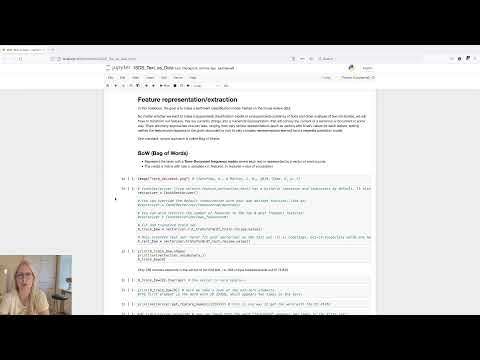

In [24]:
YouTubeVideo('xvvkx49HuuU', width=740, height=460)

In this notebook, the goal is to make a sentiment classification model trained on the movie review data. 

No matter whether we want to make a (supervised) classification model or (unsupervised) clustering of texts and other analyses of text similarities, we will have to transform our features, that are currently strings, into a numerical representation, that will convey the content of a sentence or document in some way. There are many approaches one can take, ranging from very simple representations (such as vectors with binary values for each feature, stating wether the feature/word appears in the given document or not) to very complex representations learned from a seperate prediction model.

One standard, simple approach is called Bag of Words:

## BoW (Bag of Words)

- Represent the texts with a **Term-Document frequency matrix** where each text is represented by a vector of word counts. 
- The creats a matrix with size n_samples x n_features. (n_features = size of vocabulary)

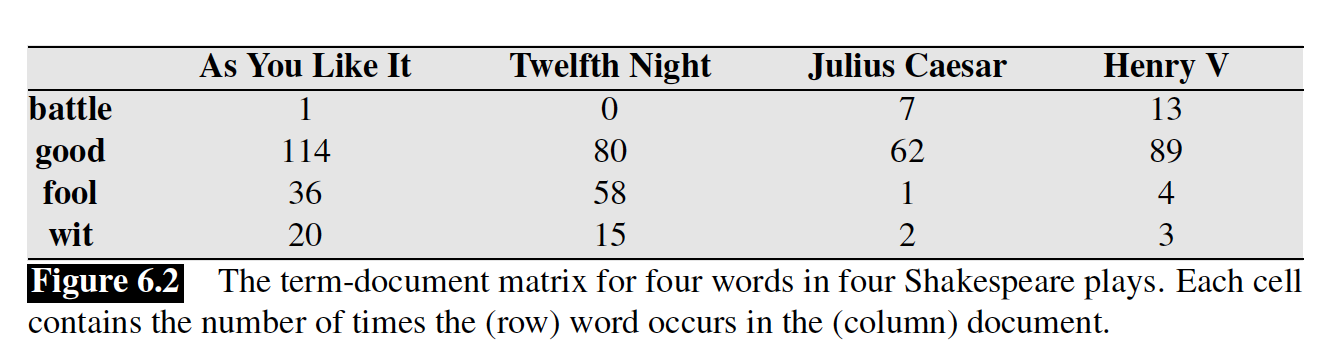

In [12]:
Image("term_document.png") # (Jurafsky, D., & Martin, J. H., 2019. Chap. 6, p. 7)

In [25]:
# CountVectorizer (from sklearn.feature_extraction.text) has a build-in tokenizer and lowercases by default. It also has an option to remove stopwords (look at the documentation).
vectorizer = CountVectorizer()

# You can override the default tokenization with your own defined function, like so:
#vectorizer = CountVectorizer(tokenizer=preprocess)

# you can also restrict the number of features to the top N most frequent features:
#vectorizer = CountVectorizer(max_features=N)

# fit and transform train set
X_train_bow = vectorizer.fit_transform(df_train.review.values)

# Only tranform test set: never fit your vectorizer on the test set (it is cheating). Out-of-Vocabulary words are handled automatically be sklearn's vectorizer.
X_test_bow = vectorizer.transform(df_test.review.values)

In [26]:
print(X_train_bow.shape)
print(len(vectorizer.vocabulary_))
X_train_bow[0]

(25000, 74849)
74849


<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 238 stored elements in Compressed Sparse Row format>

Only 238 nonzero elements in the vector of the first text, i.e. 238 unique features/words out of 74,849.

In [27]:
X_train_bow[0].toarray() # the vector is very sparse..

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [28]:
print(X_train_bow[0]) # here we take a look at the non-zero elements. 
#The first element is the word with ID 25459, which appears two times in the text.

  (0, 25459)	2
  (0, 60440)	5
  (0, 34585)	5
  (0, 6117)	1
  (0, 70377)	1
  (0, 66339)	21
  (0, 50339)	1
  (0, 61380)	2
  (0, 40829)	1
  (0, 605)	1
  (0, 26692)	2
  (0, 38755)	1
  (0, 43995)	1
  (0, 71281)	1
  (0, 68619)	2
  (0, 44164)	1
  (0, 73714)	1
  (0, 57715)	1
  (0, 40413)	1
  (0, 19563)	2
  (0, 67832)	1
  (0, 34255)	4
  (0, 18336)	1
  (0, 41950)	1
  (0, 53839)	2
  :	:
  (0, 21162)	1
  (0, 21289)	1
  (0, 42134)	1
  (0, 38507)	1
  (0, 47142)	1
  (0, 52227)	1
  (0, 31289)	1
  (0, 24125)	1
  (0, 69622)	1
  (0, 6771)	1
  (0, 37895)	1
  (0, 57675)	1
  (0, 28314)	1
  (0, 6334)	2
  (0, 12480)	1
  (0, 70505)	1
  (0, 38720)	1
  (0, 59184)	1
  (0, 43010)	1
  (0, 23199)	1
  (0, 63226)	1
  (0, 73702)	1
  (0, 66925)	1
  (0, 7095)	1
  (0, 5208)	1


In [29]:
print(vectorizer.get_feature_names()[25459]) # this is one way to get the word with the ID 25459

forbidden


In [30]:
#df_train.review.values[0] # you can check that the word "forbidden" appears two times in the first text

### N-grams 

- Collection of 1 or more tokens.

- Bag of words lacks word order and context (semantics). n-grams to the rescue!

In [31]:
example = "The cat in the hat"

In [32]:
def make_ngrams(sentence,n):
    tokens = sentence.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

print("Unigrams:",make_ngrams(example,1))
print("Bigrams:",make_ngrams(example,2))
print("Trigrams:",make_ngrams(example,3))
print("4-grams:",make_ngrams(example,4))
print("5-grams:",make_ngrams(example,5))

Unigrams: ['The', 'cat', 'in', 'the', 'hat']
Bigrams: ['The cat', 'cat in', 'in the', 'the hat']
Trigrams: ['The cat in', 'cat in the', 'in the hat']
4-grams: ['The cat in the', 'cat in the hat']
5-grams: ['The cat in the hat']


### BoW with ngrams using CountVectorizer

In [33]:
# this block can take a few minutes to run

# n=1-5
vectorizer = CountVectorizer(ngram_range=(1,5))

X_train_5gram = vectorizer.fit_transform(df_train.review.values[:2500])

In [34]:
print(X_train_5gram.shape)
X_train_5gram[0]

(2500, 1829059)


<1x1829059 sparse matrix of type '<class 'numpy.int64'>'
	with 1811 stored elements in Compressed Sparse Row format>

- But now we have problems with high dimensionalty and uniqeness of features!

- N-grams are used for many applications but are especially known from **Language Models**: In short, probalistic models that learn to predict the next word in a sequence of words, given the "history" (the previous words), simply by storing the probability of this event occuring in the given text, e.g. P(hat|The cat in the). But instead of using ALL previous word (which would be a combination of words unique to the given text), the history is approximated by a few previous words (n-grams), e.g. P(hat|the). This is the n-gram language model.



## Exercise 2: Inspect most frequent bigrams

Inspection of word collocations (bigrams, trigrams etc.) can be a good first step in exploring a new text dataset, or a single document for that matter. Such collocations will be very indicative of what the texts are about.

Make a new CountVectorizer that only includes bigrams and with max_features=1000. Fit it on the train set.

Then, practise you Googling and find a way to print the most frequent bigrams in the train set. Print the bigrams along with their frequencies in a descending order. What do you see?

In [35]:
# YOUR CODE HERE

vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=1000, stop_words={'english'})

X_train_onlybigram = vectorizer.fit_transform(df_train.review.values[:5000])

In [36]:

vocab = vectorizer.vocabulary_

count_values = X_train_onlybigram.toarray().sum(axis=0)

# output n-grams
for count, text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    print(str(count), ";", text)

10431 ; br br
8146 ; of the
5203 ; in the
3061 ; this movie
2723 ; the film
2716 ; and the
2482 ; the movie
2426 ; to be
2395 ; to the
2252 ; this film
2130 ; it is
1863 ; this is
1810 ; on the
1798 ; it was
1639 ; one of
1637 ; for the
1584 ; br the
1562 ; with the
1437 ; at the
1377 ; if you
1360 ; is the
1235 ; from the
1234 ; in this
1178 ; as the
1155 ; that the
1120 ; the story
1074 ; out of
1073 ; to see
992 ; by the
925 ; movie is
901 ; the first
900 ; there is
899 ; have been
884 ; all the
858 ; of this
854 ; film is
823 ; the end
815 ; is not
811 ; but it
803 ; there are
776 ; and it
759 ; the most
758 ; that it
740 ; the same
718 ; the best
709 ; but the
688 ; of his
682 ; about the
672 ; the plot
672 ; he is
644 ; to make
633 ; this one
625 ; that is
615 ; the only
612 ; to watch
569 ; the characters
559 ; some of
544 ; was the
542 ; to get
541 ; they are
529 ; the way
527 ; have to
521 ; is that
513 ; would have
513 ; want to
510 ; you can
499 ; into the
498 ; the acting
4

## Term Frequency–Inverse Document Frequency (TF-IDF)

The tf-idf value of term t in document d is:

TF-IDF(t,d) = tf(t,d) x idf(t)

where,

tf(t,d) = count of term t in document d

N = total number of documents

df(t) = number of documents that term t occurs in

idf(t) = N/df(t)

A "term" is a token in our case.

In [42]:
#Image("tf_idf.png") # (Jurafsky, D., & Martin, J. H., 2019. Chap. 6, p. 14)

In [43]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(df_train.review.values)

### Document similarity with tf-idf vectors

In [39]:
X_train_tfidf[0].shape

(1, 74849)

In [40]:
# https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
cosine_similarities = cosine_similarity(X_train_tfidf[0], X_train_tfidf).flatten()

indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])

most similar: [    0 23558 23470 17790  4719 24385 20550  6001  6096 20886]
least similar [14867 11975 17497  5623  9340 14494 18802 16480 23603]


In [41]:
print(df_train.review.values[0])
print()
print("most similar: ", df_train.review.values[23558])
print()
print("least similar: ", df_train.review.values[23603])

Forbidden Siren is based upon the Siren 2 Playstation 2 (so many 2s) game. Like most video game turned movies, I would say the majority don't translate into a different medium really well. And that goes for this one too, painfully.<br /><br />There's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (Leo Morimoto) and his children, daughter Yuki (Yui Ichikawa) and son Hideo (Jun Nishiyama) come to move into. The villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />Naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. But in truth, you will not bother with what's going on, as folklore and fairy tales get thrown in to convolute the plot even more. What was really push

The similar text is also about a movie based on a video games! Also notice the similarity of lengths and that the least similar review is very short.

## Vector semantics / Vector Space Models / (word) embeddings

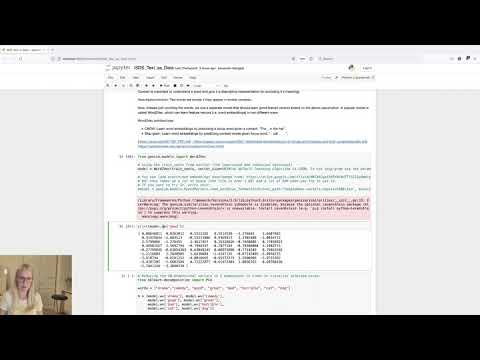

In [44]:
YouTubeVideo('hcfgqgGHF4M', width=740, height=460)

Semantics: The *meaning* or catagory of a word.

Context is important to understand a word and give it a descriptive representation (to encoding it's meaning). 

Assumption/intution: Two words are similar if they appear in similar contexts.

Now, instead just counting the words, we use a seperate model that should learn good feature vectors based on the above assumption. A popular model is called Word2Vec, which can learn feature vectors (i.e. word embeddings) in two different ways:


Word2Vec architectures:

- CBOW: Learn word embeddings by predicting a focus word given a context. "The _ in the hat".

- Skip-gram: Learn word embeddings by predicting context words given focus word. "_ cat _ _ _".

(https://arxiv.org/pdf/1301.3781.pdf ,
https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf, https://radimrehurek.com/gensim/models/word2vec.html)

In [47]:
from gensim.models import Word2Vec

# using the train_sents from earlier (the lowercased and tokenized sentences)
model = Word2Vec(train_sents, vector_size=50)#the default learning algorithm is CBOW. To use skip-gram use the paramter sg=1.

# You can load pretrained embeddings downloaded from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing 
# BUT this takes up a lot of space (the file is over 1 GB) and a lot of RAM when you try to use it.
# If you want to try it, write this:
#model = gensim.models.KeyedVectors.load_word2vec_format(directory_path+'GoogleNews-vectors-negative300.bin', binary=True)


C:\Users\danib\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [48]:
print(model.wv['good'])

[ 0.71270806 -0.31769142 -1.4951129   0.8117136  -0.30582118  4.768937
  0.65136933 -1.4646083  -2.8920631   2.4352632   1.6365921   1.3991555
  1.2314132  -4.2850885   0.12885392  0.45901167 -2.4860027   1.2170495
 -0.585563    1.7488027  -1.1196803  -1.9225163   0.38394094  3.2242901
 -2.342125   -1.6705306   1.2655326  -2.3950536   0.27393886 -2.4314296
 -1.9280926  -0.765239    2.0888648  -1.7141681   1.4703386  -6.6484036
  0.3249095  -0.9029476  -1.3360982   0.4280918   4.8129597  -1.7365242
 -3.646814   -1.4186025   0.3239006  -0.70414984  0.4201299  -0.99568295
 -1.3297943  -2.3665621 ]


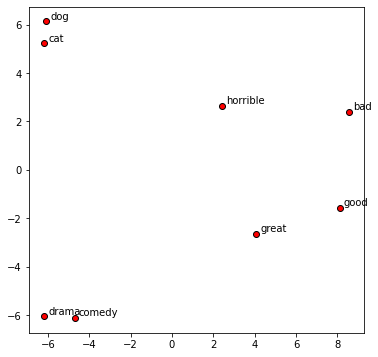

In [49]:
# Reducing the 50-dimensional vectors to 2 dimensions in order to visualise selected words.
from sklearn.decomposition import PCA

words = ["drama","comedy", "good", "great", "bad", "horrible", "cat", "dog"]

X = [model.wv['drama'], model.wv['comedy'], 
     model.wv['good'], model.wv['great'], 
     model.wv['bad'], model.wv['horrible'], 
     model.wv['cat'], model.wv['dog']]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_r[:,0], X_r[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, X_r):
    plt.text(x+0.2, y+0.1, word)

We now have a unique embedding vector mapped to each word. But what if we want to work with sentences/documents that contain many words and with a variying number of words in them? If you are doing machine learning (and are not using some fancy model that can handle varying lengts), the input vectors for your model have to be of same length. And the input of one element (for example one document), should preferably be a vector rather than a matrix (i.e. having an array with arrays of word embeddings as input will not work in most cases). So you need to make a decision of how to to use word embeddings for such cases. 

You could, for example, concatenate the vectors and choose a cut-off point for a given maximum number of words, where every sentence longer than that will be cut short, and every sentence shorter will be appended vectors containing zeroes. Or you can simply take the mean at axis 0, such that each document is represented by a single vector of length 50. I show the latter here:

In [50]:
# Take the mean of the word vectors to get one vector for each text 
# (rather than a list of word vectors for each text)

embedded_text = np.array([np.mean([model.wv[w] if w in model.wv.key_to_index.keys() else np.zeros(50) for w in words], axis=0) for words in train_sents])

In [51]:
embedded_text.shape

(25000, 50)

You can now check similarities between documents/reviews again and see how the results differ. You can also you the document embeddings in a Machine Learning model or for some type of clustering.

Optional: Check whether increasing the vector_size for the word2vec model makes the similarites more meaningful.

In [52]:
# Using the averaged word2vec document embeddings to find similar documents:
cosine_similarities = cosine_similarity(embedded_text[0].reshape(1,50), embedded_text[:]).flatten()
indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])
print(df_train.review.values[0])
print()
print("most similar: ", df_train.review.values[5052])
print()
print("least similar: ", df_train.review.values[22007])

most similar: [    0 13599 22472  2360  5853  3280  5052  9144 17951 24254]
least similar [16452 12780 10288  9527 22666 18819  7270 19309 22007]
Forbidden Siren is based upon the Siren 2 Playstation 2 (so many 2s) game. Like most video game turned movies, I would say the majority don't translate into a different medium really well. And that goes for this one too, painfully.<br /><br />There's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (Leo Morimoto) and his children, daughter Yuki (Yui Ichikawa) and son Hideo (Jun Nishiyama) come to move into. The villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />Naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. But i

There exists many methods for learning good word embeddings, and a lot of pre-trained options as well, but these a primarily available for English text. Here are three other popular options besides Word2Vec, for those who are interested in diving more into that (but I do not expect you to do so for this course):
- FastText
- Glove
- BERT

BERT is currently the most widely used model for representing text, especially it's large pretrained embeddings. But it is perhaps also more complex to get started with, and definetly less interpretable.

# Text classification

We will now build a classifier that will classify text as having a positive (1) or negative (0) sentiment!

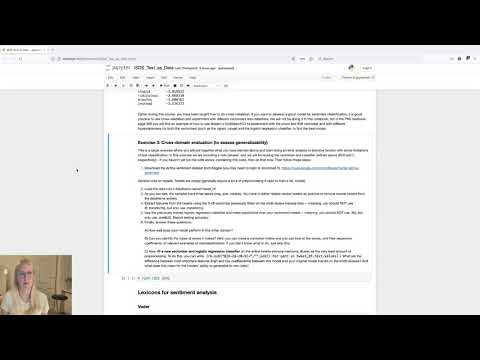

In [45]:
YouTubeVideo('1OFSYHkecbA', width=740, height=460)

## Text classification with logistic regression

In [53]:
# Get feature vectors
tfidf = TfidfVectorizer()
# use your own preprocessing function in the vectorizer when you've finished that exercise:
#tfidf = TfidfVectorizer(tokenizer=preprocess)
X_train_tfidf = tfidf.fit_transform(df_train.review.values)
X_test_tfidf = tfidf.transform(df_test.review.values)

# labels
y_train = df_train.sentiment.values
y_test = df_test.sentiment.values

# classifier
lr = LogisticRegression(random_state=0)

#training
lr.fit(X_train_tfidf,y_train)

#testing
train_preds = lr.predict(X_train_tfidf)
test_preds = lr.predict(X_test_tfidf)
print("training accuracy:", np.mean([(train_preds==y_train)]))
print("testing accuracy:", np.mean([(test_preds==y_test)]))

training accuracy: 0.93328
testing accuracy: 0.88316


### Let's look at the features' coeffiecients

Training a logistic regression classifier and inspecting the coefficients is a great - and simple - way to learn what words are important for a class/category. You can use the result in a word cloud! Or if you have texts written by, for example, two political parties and with sentiment labels (or some other labels) you can train a model on each party and compare most important words - this can tell you something about the language use in different parties, and if using higher orders of n-grams, you may see which subjects are more often talked about in a positive/negative manner.

In [54]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

,00,000,0000000000001,00001,00015,000s,001,003830,006,007,...,était,état,étc,évery,êxtase,ís,ísnt,østbye,über,üvegtigris
0,-0.096569,-0.305337,-0.033966,-0.038521,-0.005573,0.024453,-0.032348,0.031637,0.013828,0.056278,...,0.041276,0.047509,0.034055,-0.081397,0.016038,0.002182,-0.035297,0.01018,-0.084577,-0.053029


In [55]:
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

                   0
great       7.597993
excellent   6.185474
best        5.127967
perfect     4.818600
wonderful   4.676444
amazing     4.164898
well        4.061736
loved       3.835260
fun         3.805573
today       3.782701
love        3.782314
favorite    3.743822
enjoyed     3.513010
highly      3.390157
brilliant   3.353821
it          3.330147
superb      3.321679
and         3.176546
definitely  3.031838
still       2.983629

                      0
worst         -9.242321
bad           -7.956060
awful         -6.493183
waste         -6.278238
boring        -6.020011
poor          -5.448303
terrible      -4.848693
nothing       -4.761642
worse         -4.577197
no            -4.394958
horrible      -4.208934
poorly        -4.167156
dull          -4.155190
unfortunately -3.984436
script        -3.871557
annoying      -3.827654
stupid        -3.818522
ridiculous    -3.668310
minutes       -3.600162
instead       -3.526372


Earlier during this course, you have been taught how to do cross-validation. If you want to develop a good model for sentiment classification, it is good practice to use cross-validation and experiment with different vectorizers and classifiers. We will not be doing it in this notebook, but in the PML textbook page 268 you will find an example of how to use sklearn's GridSearchCV to experiment with the count and tfidf vectorizer and with different hyperparamters for both the vectorizers (such as the ngram_range) and the logistic regression classifier, to find the best model.

### Exercise 3: Cross-domain evaluation (to assess generalizability)

This is a larger exercise where you will put together what you have learned above and start doing an error analysis to become familiar with some limitations of text classification. In this exercise we are including a new dataset, and we will be reusing the vectorizer and classifier defined above (tfidf and lr, respectively) - if you haven't yet run the cells above, containing this code, then do that now. Then follow these steps:

1. Download the Airline sentiment dataset from Kaggle (you may need to login to download it): https://www.kaggle.com/crowdflower/twitter-airline-sentiment

General note on tweets: Tweets are messy (generally require a lot a of preproccesing if used to train a ML model).

2. Load the data into a dataframe named tweet_df. 

3. As you can see, the samples have three labels (neg, pos, neutral). You have to either relabel neutral tweets as positive or remove neutral tweets from the dataframe entirely.

4. Extract features from the tweets using the tf-idf vectorizer previously fitted on the Imdb review training data -- meaning, you should NOT use fit_transform(), but only use .transform().

5. Use the previously trained logistic regression classifier and make predictions over your vectorized tweets -- meaning, you should NOT use .fit(), but only use .predict(). Report testing accuracy.

6. Finally, answer these questions:

    A) How well does your model perform in this other domain? 
    
    B) Can you identify the types of errors it makes? (hint: you can make a confusion matrix and you can look at the words, and their respective coefficients, of relevant examples of misclassification). If you don't know what to do, just skip this.
    
    C) Now, **fit a new vectorizer and logistic regression classifier** on the airline tweets (remove mentions, @user, as the very least amount of preprocessing. To do this, you can write ```[re.sub("@[A-Za-z0-9]+","",sent) for sent in tweet_df.text.values]```). What are the difference between most important features (high and low coeffiecients) between this model and your original model trained on the Imdb reviews? And what does this mean for the models' ability to generalize to new data?

In [ ]:
# YOUR CODE HERE

## Lexicons for sentiment analysis 

### Vader 

In [ ]:
# Vader lexicon
analyser = vaderSentiment.SentimentIntensityAnalyzer()
snt = analyser.polarity_scores(sentence)
#print(sentence)
print(snt)
compound = snt["compound"] # how to scoring works: https://github.com/cjhutto/vaderSentiment#about-the-scoring

### Afinn 

In [ ]:
# Afinn lexicon
afn = Afinn(emoticons=True)
print(afn.score(sentence))

In [ ]:
example_neg = "congrats on making an all-together predictable movie"
example_pos = "OMG I literally died!"

print(afn.score(example_neg))
print(afn.score(example_pos))

### SentiWordNet 

In [ ]:
# lexicon can be accessed with NLTK:
nltk.download('sentiwordnet')
good = nltk.corpus.sentiwordnet.senti_synsets('good', 'a') # a=adjective
for i in good:
    print(i)
print()

print("good.a.01 Definition: ", nltk.corpus.wordnet.synset('good.a.01').definition())
print("good.a.03 Definition: ", nltk.corpus.wordnet.synset('good.a.03').definition())

### Exercise 4: Lexicon-based sentiment classification (no Machine Learning)
Use the Vader lexicon to classify each review in the test set. Use the "compound" score where compound<=0 = negative review (0) and compound>0=positive review (1). Report the classification accuracy.

In [ ]:
#Your code here

# EXTRA 

### Topic Modelling example

See https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ 

In [ ]:
from gensim.models import ldamodel
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(train_sents)

# Create Corpus
texts = train_sents

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = ldamodel.LdaModel(corpus=corpus,
                               id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
lda_model.print_topics()

## Some NLP resources

**NLTK** (as we have seen): Basic NLP tools such as tokenization, stemming, lemmatization, part-of-speech tagging (though not as good as the one from stanfordNLP), dependency parsing. https://www.nltk.org. Good introductory material here: https://www.nltk.org/book/

**Wordnet**: A large lexicon of "synsets"; groups of words that are semantically closely related (synonyms). It can be used to infer word senses/meanings among other things https://wordnet.princeton.edu. 

**StanfordNLP (stanza)**: Tokenization, part-of-speech tagging, dependency parsing, named entity recognition, and more. https://stanfordnlp.github.io/stanza/.

**Spacy**: More advanced NLP pipelines for feature extraction and more https://spacy.io

**Gensim**: Popular models for word embeddings, e.g. word2vec and fastText, and more. https://radimrehurek.com/gensim/auto_examples/index.html


## Project ideas

- Predicting election outcomes or market trends from sentiment
- Stance or sentiment towards political parties
- Hate speech detection
- Analysing overaching topics in a debate


# Summary


You've learned:
- What to consider when preprocessing text
- How to represent texts with numerical vectors
- That you can find similar texts by calculating the distance between their vectors.
- What word embeddings are and the basic intuition of it
- Text classification
- Possibilities with lexicons